# Introduction

The "I'm Something of a Painter Myself" competition provides two sets of data in a tfrec and jpg format. Each image is 256px by 256px. The goal of this competition is to use a GAN Architecture to generate images in the style of Monet. In this notebok, we utilize a CycleGAN architecture to generate two sets of submission. Each model has tweaks to the hyperparameters so that we can tell the performance difference in each model as it relates to accuracy in translating a normal photo into a monet styled image. For this notebook, we leveraged the introduction tutorial: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

And the two cycle gan tutorials:
<p>1) https://keras.io/examples/generative/cyclegan/<br>
2) https://www.tensorflow.org/tutorials/generative/cyclegan</p>

In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

2024-06-15 01:52:53.295159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 01:52:53.295244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 01:52:53.558813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA
In the tensorflow tutorial, they develop a model that translates images of horses to zebras. For our case, we would like to develop a model that translates the features of monet photos to other real photos. Before we begin, lets visualize some of the photos from each set of data.

In [2]:
monet_images_path = '/kaggle/input/monet-gan-getting-started/monet_jpg'
non_monet_images_path = '/kaggle/input/monet-gan-getting-started/photo_jpg'

def images_in_directory(image_path):
    images = []
    for directory, _, files in os.walk(image_path):
        for file in files:
            image_path = os.path.join(directory, file)
            images.append(image_path)
    print(f'Number of images in directory: {len(images)}')
    return images    

In [3]:
monet_images = images_in_directory(monet_images_path)
non_monet_images = images_in_directory(non_monet_images_path)

Number of images in directory: 300
Number of images in directory: 7038


In each of our directories, there are 300 monet images and 7038 non monet images. We can take a look at the images and plot both together.

In [4]:
import cv2
def display_images(images, rows, columns):
    figure, ax = plt.subplots(nrows=rows,ncols=columns,figsize=(16,8) )
    for ind,image in enumerate(images):
        image=cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

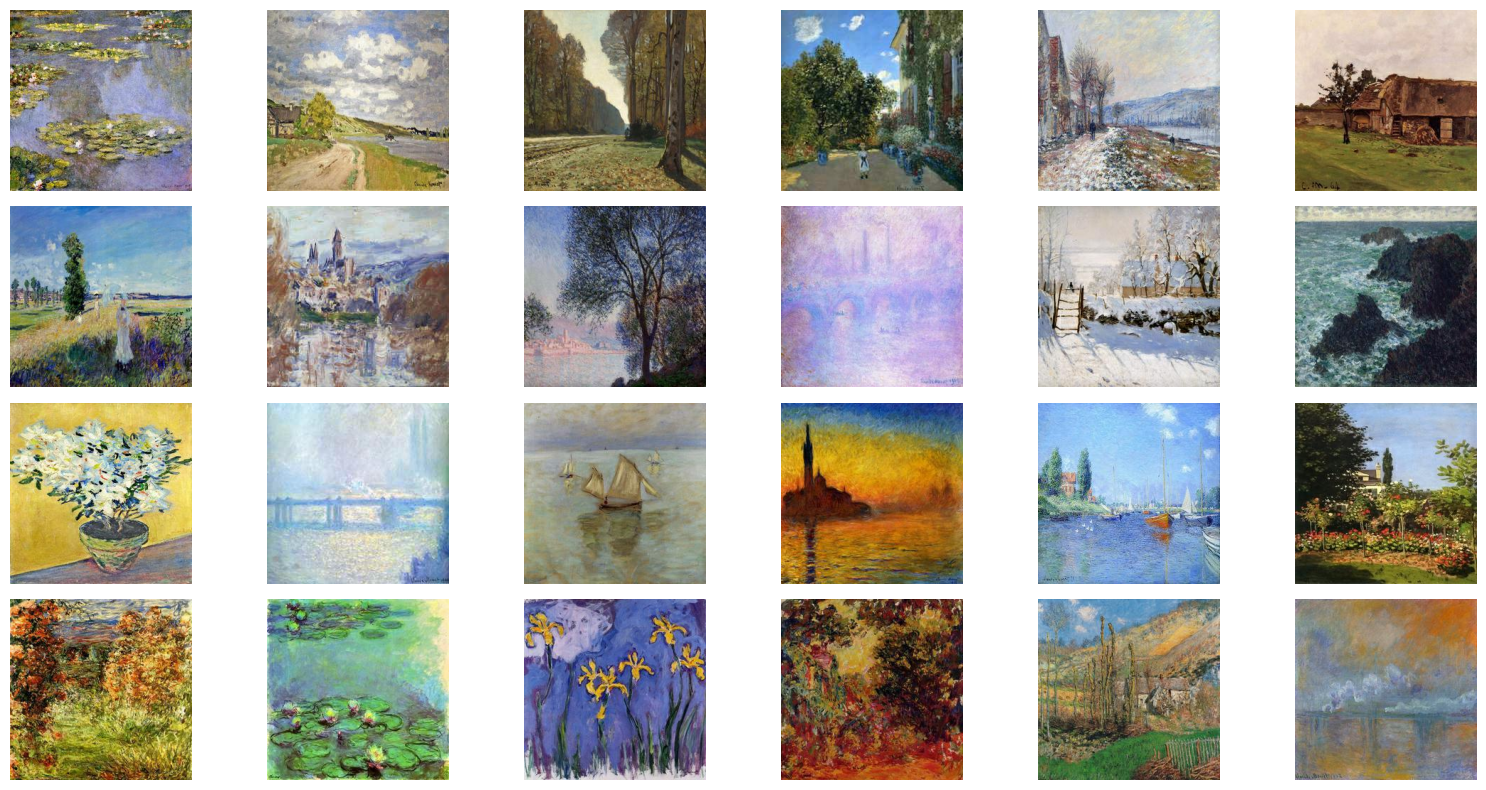

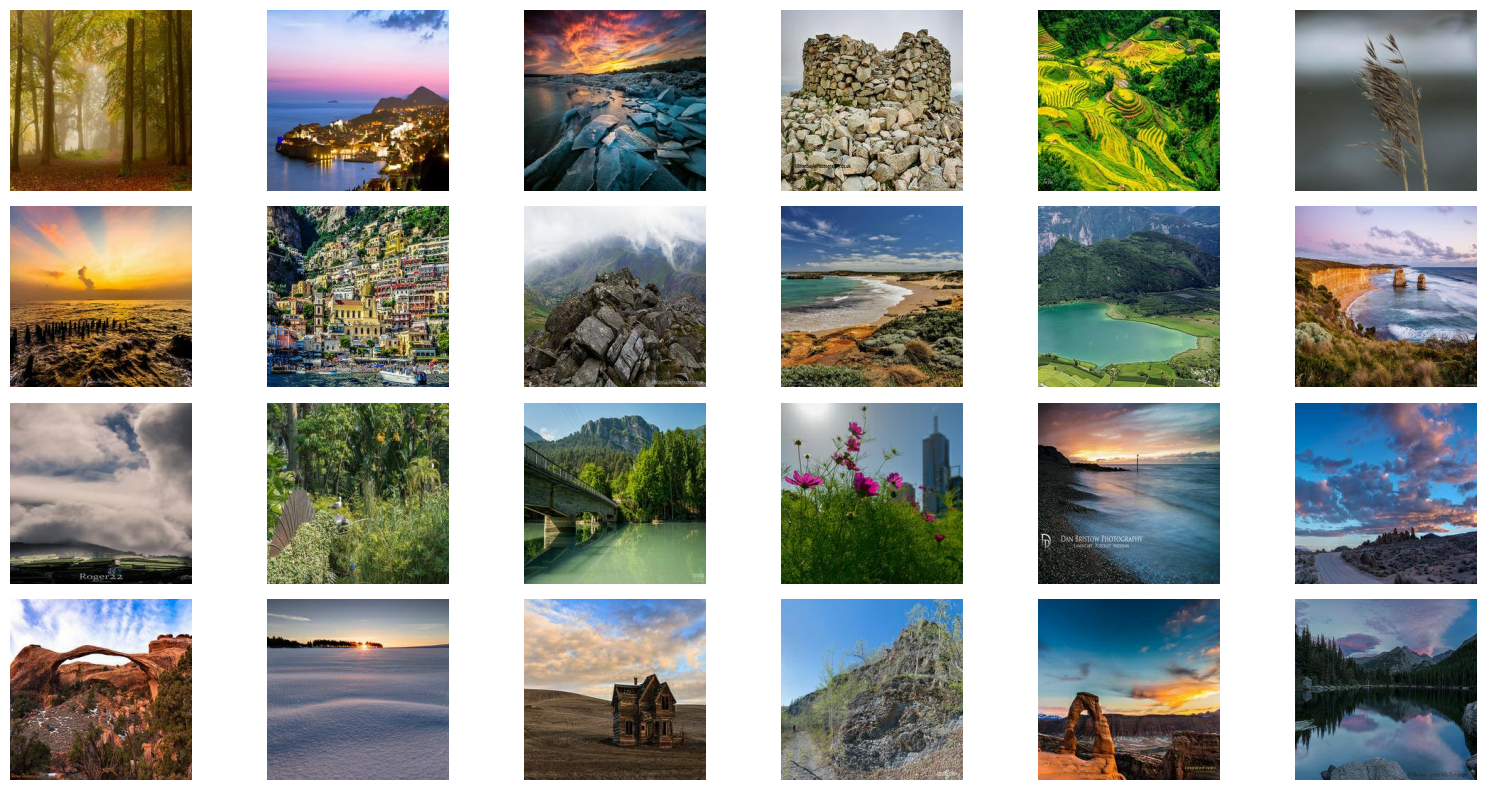

In [5]:
images = [monet_images, non_monet_images]

for image in images:
    display_images(image,4,6)

Notice above in the first 4 rows, we have a visualization of what a monet looks like and in the bottom 4 rows, we have images for which we would like to translate the monet features to. For this project, we do not need to clean the datasets.

Following the basic tutorial, we can begin to follow the same structure and develop an understanding for each step. In this step, we are loading in data from a TFRecord. A TFRecord is good for working with large datasets. In our instance, this dataset could be considered large when looking at the .jpg files earlier in this notebook. The reason a TFRecord is good is that it stores data as a binary file which means that the data is saved within a single block of memory. Without a TFRecord, images would be stored seperate from any of their annotations. For more information take a look at: https://tensorflow.google.cn/tutorials/load_data/tfrecord#tfrecord_files_in_python.

Note: The following cells are derived from this reference: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial. This notebook has updates to the model  to be able to work with the latest python packages and TPU accelerator on kaggle.

In [6]:
#TPU's provide a big performance boost when compared to CPU's and GPU's
#Reference: https://blog.purestorage.com/purely-educational/tpus-vs-gpus-whats-the-difference/
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.15.0


In [7]:
#Checks the number of TFRecord files in the photo and monet directories
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/monet-gan-getting-started/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/monet-gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [8]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [9]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Model Architecture

In the example notebook for getting started, we will leverage the generator, discriminator, and cycleGan model code which is in the following cell. The intention of this is that once we train using the getting started model, we will then test the model again after applying image augmentation techniques to see how this will impact the model itself. Once again the code in the following cells comes from  https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial.

Before we continue, lets understand each piece of the model. The generator will take in an input image, the inputed image will then be down sampled and then upsampled. The discriminator takes in an input image and outputs a tensor. To achieve downsampling, we leverage a 2D convolutional layer and to achieve upsampling we leverage a transposed 2D convolutional layer.

To simplify this understanding, a generator will learn to transform or translate features of one image to another and a discriminator learns to differentiate between an image and its generated counterpart.

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.BatchNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.BatchNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [12]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


I0000 00:00:1718416586.475154     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 179s 207ms/step - monet_disc_loss: 0.6316 - monet_gen_loss: 5.1364 - photo_disc_loss: 0.6021 - photo_gen_loss: 5.2842
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - monet_disc_loss: 0.6595 - monet_gen_loss: 3.5797 - photo_disc_loss: 0.6358 - photo_gen_loss: 3.6424
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 3.5461 - photo_disc_loss: 0.6130 - photo_gen_loss: 3.6388
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6330 - monet_gen_loss: 3.4479 - photo_disc_loss: 0.6083 - photo_gen_loss: 3.5498
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 3.2989 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.3985
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 3.1822 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.2766
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 3.1084 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.2129
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_l

In [23]:
import PIL
! mkdir ../images_no_aug


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [24]:
from tqdm import tqdm
i = 1
for img in tqdm(photo_ds):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images_no_aug/" + str(i) + ".jpg")
    i += 1
    


7038it [05:45, 20.39it/s]


In [25]:
import shutil
shutil.make_archive("/kaggle/working/images_no_aug", 'zip', "/kaggle/images_no_aug")

'/kaggle/working/images_no_aug.zip'

# Modifications
Now that we have gone through and understood what was happening in the getting started notebook, lets take a look at how we might be able to improve the model. In the CycleGan tutorial (https://www.tensorflow.org/tutorials/generative/cyclegan) there is image augmentation performed. By applying image augmentation, it can help to avoid overfitting in the model. In this section, we will apply some image augmentation techniques and then use the model above to validate whether there was any improvement at all with these efforts.

In [26]:
#Reference https://www.tensorflow.org/tutorials/images/data_augmentation
def image_rotation(image):
    try:
        # Define rotation angles
        rotation_angles = tf.constant([0, 1, 2, 3], dtype=tf.int32)  # 0, 90, 180, 270 degrees
        
        # Shuffle rotation angles and choose one randomly
        shuffled_angles = tf.random.shuffle(rotation_angles)
        rotation_angle = shuffled_angles[0]
        
        # Rotate based on the randomly chosen rotation angle
        image = tf.image.rot90(image, k=rotation_angle)
    except Exception as e:
        print("Error in image rotation:", e)
    return image

def image_flip(image):
    try:
        return tf.image.random_flip_left_right(tf.image.random_flip_up_down(image))
    except Exception as e:
        print("Error in image flip:", e)
        return image

def image_transpose(image):
    try:
        return tf.image.transpose(image)
    except Exception as e:
        print("Error in image transpose:", e)
        return image

In [27]:
def load_dataset_with_augments(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(image_rotation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(image_flip, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(image_transpose, num_parallel_calls=AUTOTUNE)
    
    return dataset

In [28]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - monet_disc_loss: 0.6327 - monet_gen_loss: 2.6111 - photo_disc_loss: 0.6311 - photo_gen_loss: 2.7126
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - monet_disc_loss: 0.6332 - monet_gen_loss: 2.6625 - photo_disc_loss: 0.6279 - photo_gen_loss: 2.7091
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - monet_disc_loss: 0.6421 - monet_gen_loss: 2.5705 - photo_disc_loss: 0.6250 - photo_gen_loss: 2.6729
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.7248 - photo_disc_loss: 0.6036 - photo_gen_loss: 2.7518
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.5805 - monet_gen_loss: 2.8466 - photo_disc_loss: 0.5830 - photo_gen_loss: 2.8646
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - monet_disc_loss: 0.6307 - monet_gen_loss: 2.6369 - photo_disc_loss: 0.6172 - photo_gen_loss: 2.7153
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - m

In [29]:
! mkdir ../images

In [30]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [31]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Conclusion
Before applying data augmentation, the model achieved a score of 73.46995. After data augmentation, the score improved to 69.70267. This shows that the model did perform better with image augmentation. There are several items which we could do to make the model perform better. I would have like more time to tune the hyperparameters to see how that affects the model as well as implementing other architectures. In this notebook, the model leverages a unet architecture; however, it would interesting to see how the ResNet architecture performs. If provided more time, I would have also liked to look into balancing the discriminator and generator better. 

## References
All references are documented throughout this notebook in markdown blocks and in code comments.

